# Машинное обучение в задачах идентификации личности по голосу    
**Выполнил**: Карымов Игорь  
**Группа**: ПМ22-7

## Импорт библиотек

In [302]:
from datasets import load_dataset
from librosa.feature import mfcc
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ParameterGrid
import sklearn
import pandas as pd
from librosa import lpc
import librosa
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from time import time
import scipy
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import StackingClassifier, BaggingClassifier

## Загрузка датасета с Hugging Face

In [2]:
dataset = load_dataset("librispeech_asr", trust_remote_code=True, streaming=True, split='test.clean')

### Краткое описание датасета    
LibriSpeech - это корпус из примерно 1000 часов английской речи с частотой чтения 16 кГц, подготовленный Василием Панайотовым при содействии Дэниела Пови. Данные взяты из прочитанных аудиокниг проекта LibriVox и были тщательно сегментированы и выровнены.    

Поля данных        
file: путь к загруженному аудиофайлу в формате .flac    
audio: словарь, содержащий путь к загруженному аудиофайлу, расшифрованный аудиоматериал и частоту дискретизации     
text: транскрипция аудиофайла    
id: уникальный идентификатор выборки данных    
speaker_id: уникальный идентификатор говорящего     
chapter_id: идентификатор главы аудиокниги, которая содержит транскрипцию    

## Предварительный анализ данных

Преобразование датасета в датафрейм

In [3]:
DF = pd.DataFrame(dataset)

Создание резервной копии датафрейма

In [4]:
df = DF.copy()

Удаление ненужных признаков и переименование оставшихся

In [5]:
df = pd.concat([df,df.audio.apply(pd.Series)],axis=1).drop(['file', 'text', 'chapter_id', 'id', 'path', 'audio'],axis=1)
df.columns = ['speaker_id', 'audio_array', 'sampling_rate']
df.head()

,speaker_id,audio_array,sampling_rate
0,6930,"[-6.103515625e-05, 9.1552734375e-05, 0.0010681...",16000
1,6930,"[-0.005706787109375, -0.00732421875, 0.0051269...",16000
2,6930,"[0.00091552734375, 0.00115966796875, 0.0010375...",16000
3,6930,"[0.003265380859375, -0.002777099609375, -0.001...",16000
4,6930,"[-0.008819580078125, -0.001983642578125, 0.005...",16000


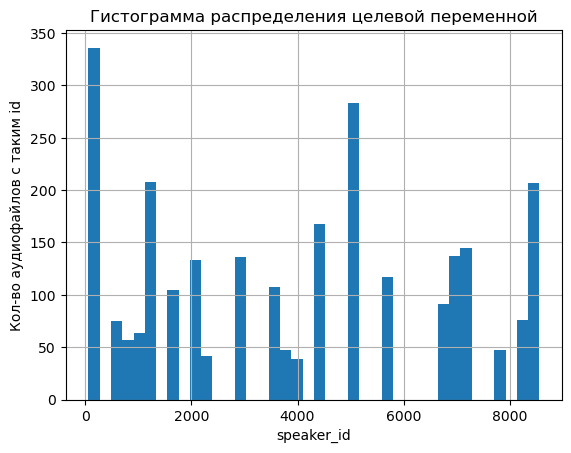

In [6]:
df.speaker_id.hist(bins=len(df.speaker_id.unique()))
plt.title('Гистограмма распределения целевой переменной')
plt.ylabel('Кол-во аудиофайлов с таким id')
plt.xlabel('speaker_id')
plt.show()

### Наблюдается дисбаланс классов, поэтому для оценки моделей буду использовать взвешенный f1, так как эта метрика рассчитывает f1 для каждого класса и находит их среднее значение, взвешенное по количеству истинных экземпляров для каждой класса.

## Построение признаков

### Мел-частотные кепстральные коэффициенты    
Учёные выяснили, что человек воспринимает частоты звука по-разному. Низкие частоты более значимы для нас, высокие – менее значимы.    

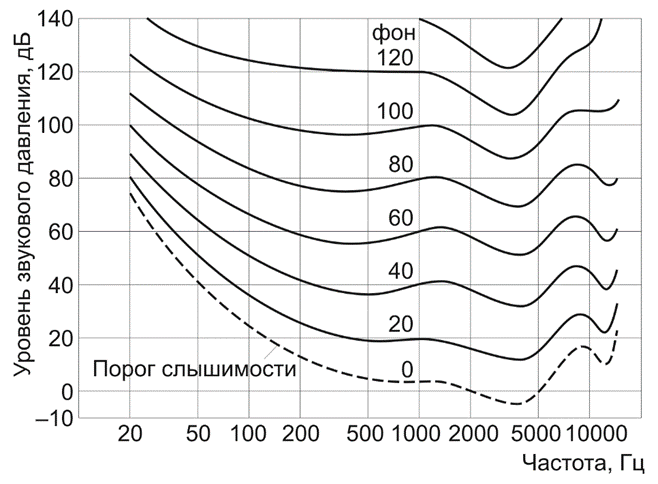

Нелинейная шкала, показывающая значимость частот звука для человека, называется мел-шкалой.    
Значения из герц в значения мел-шкалы могут быть пересчитаны по простой формуле:

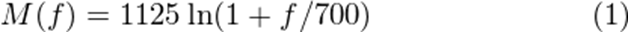

In [7]:
signal = df.audio_array[0]

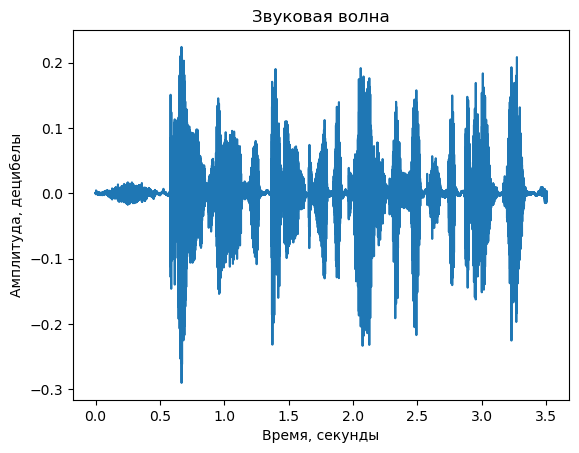

In [8]:
y = signal
x = np.arange(len(y))/16000
plt.title('Звуковая волна')
plt.ylabel('Амплитуда, децибелы')
plt.xlabel('Время, секунды')
plt.plot(x, y)
plt.show()

Text(0, 0.5, 'Amplitude')

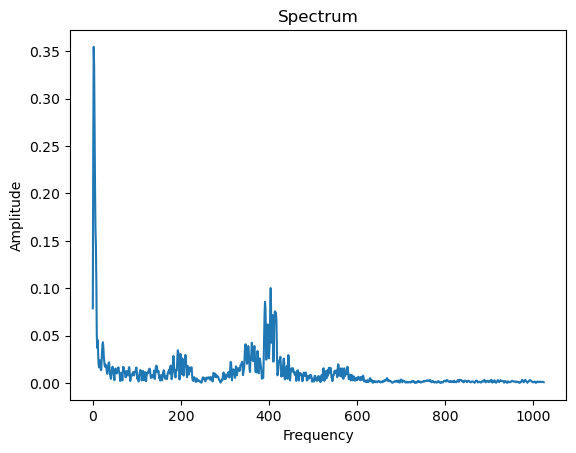

In [9]:
n_fft = 2048
ft = np.abs(librosa.stft(signal[:n_fft], hop_length = n_fft+1))
plt.plot(ft)
plt.title('Spectrum')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

На спектрограмме видно, что основная информация собрана в области низких и средних частот.

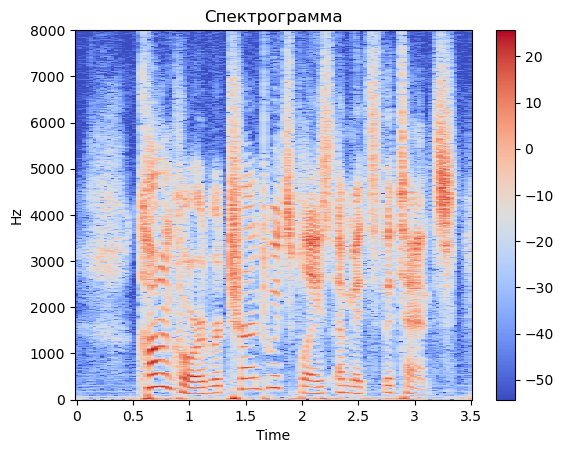

In [10]:
X = librosa.stft(signal)
s = librosa.amplitude_to_db(abs(X))
librosa.display.specshow(s, sr=16000, x_axis = 'time', y_axis='linear')
plt.colorbar()
plt.title('Спектрограмма')
plt.show()

#### Мел-кепcтральные коэффициенты (MFCC) являются одним из важнейших признаков в обработке аудио. Процесс вычисления данных коэффициентов учитывает ряд особенностей слухового анализатора человека, моделируя характеристики человеческого голоса.  Это связано с тем, что звуки, воспроизводимые человеком, определяется формой голосового тракта, включая язык, зубы и т.д.

In [11]:
def mfcc_(batch, n):
    audio_array = batch['audio_array']
    rate = batch['sampling_rate']
    mfccs = mfcc(y=audio_array, sr=rate, n_mfcc=n)
    mfcc_mean = mfccs.mean(axis=1)
    mfcc_std = mfccs.std(axis=1)
    return mfcc_mean, mfcc_std
    
def add_mfcc(df, n=13):
    mean_std_df = df.apply(lambda x: mfcc_(x, n=n), axis=1).apply(pd.Series)
    mfcc_mean_df = mean_std_df[0].apply(pd.Series)
    mfcc_mean_df.columns = [f'mfcc_mean_{n}' for n in range(1, n+1)]
    mfcc_std_df = mean_std_df[1].apply(pd.Series)
    mfcc_std_df.columns = [f'mfcc_std_{n}' for n in range(1, n+1)]
    return pd.concat([mfcc_mean_df, mfcc_std_df],axis=1)

In [280]:
mfcc_df = add_mfcc(df)

In [281]:
mfcc_df.head()

,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,...,mfcc_std_4,mfcc_std_5,mfcc_std_6,mfcc_std_7,mfcc_std_8,mfcc_std_9,mfcc_std_10,mfcc_std_11,mfcc_std_12,mfcc_std_13
0,-305.636781,14.479371,-13.723803,57.836967,-30.683759,28.041073,-12.865450,-4.944065,2.266993,7.818210,...,25.333528,19.481001,17.242129,16.973762,17.490482,11.757950,15.368954,7.701847,10.728212,12.094657
1,-270.185502,18.394196,-17.689889,72.626128,-32.793131,17.094750,-12.735961,-6.703136,2.268759,1.989206,...,29.373098,20.711823,16.682346,15.949933,14.122995,11.561662,16.334057,11.674498,10.369921,11.110519
2,-274.003011,36.557182,-27.480394,65.777843,-34.162856,18.018577,-18.948340,-7.260567,2.555662,1.876616,...,29.674870,22.430603,20.739138,20.126257,16.413892,13.134560,14.343244,12.082557,9.446889,9.693210
3,-268.464424,15.854851,-20.815412,74.652523,-34.421598,15.651378,-10.870236,-4.552543,1.434747,1.765074,...,32.929575,22.647978,17.112111,16.949865,15.601367,11.866091,15.453124,11.190739,10.526851,10.953408
4,-284.458395,35.075027,-27.258638,65.960125,-34.337090,19.049896,-12.060438,-6.349278,3.859591,4.988733,...,31.868909,24.979401,14.785186,17.512498,15.618419,10.895835,14.860691,9.987701,8.646317,10.331254


In [282]:
df_with_mfcc = pd.concat([df, mfcc_df],axis=1).drop(['audio_array', 'sampling_rate'], axis=1)
df_with_mfcc.head()

,speaker_id,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,...,mfcc_std_4,mfcc_std_5,mfcc_std_6,mfcc_std_7,mfcc_std_8,mfcc_std_9,mfcc_std_10,mfcc_std_11,mfcc_std_12,mfcc_std_13
0,6930,-305.636781,14.479371,-13.723803,57.836967,-30.683759,28.041073,-12.865450,-4.944065,2.266993,...,25.333528,19.481001,17.242129,16.973762,17.490482,11.757950,15.368954,7.701847,10.728212,12.094657
1,6930,-270.185502,18.394196,-17.689889,72.626128,-32.793131,17.094750,-12.735961,-6.703136,2.268759,...,29.373098,20.711823,16.682346,15.949933,14.122995,11.561662,16.334057,11.674498,10.369921,11.110519
2,6930,-274.003011,36.557182,-27.480394,65.777843,-34.162856,18.018577,-18.948340,-7.260567,2.555662,...,29.674870,22.430603,20.739138,20.126257,16.413892,13.134560,14.343244,12.082557,9.446889,9.693210
3,6930,-268.464424,15.854851,-20.815412,74.652523,-34.421598,15.651378,-10.870236,-4.552543,1.434747,...,32.929575,22.647978,17.112111,16.949865,15.601367,11.866091,15.453124,11.190739,10.526851,10.953408
4,6930,-284.458395,35.075027,-27.258638,65.960125,-34.337090,19.049896,-12.060438,-6.349278,3.859591,...,31.868909,24.979401,14.785186,17.512498,15.618419,10.895835,14.860691,9.987701,8.646317,10.331254


# Подбор скелера, кол-ва MFCC, модели и её параметров

In [13]:
n_mfcc_lst = [13, 21, 34, 55, 89]

In [14]:
mfcc_dfs = [add_mfcc(df, n) for n in n_mfcc_lst]

In [15]:
mfcc_dfs_dct = dict(zip(n_mfcc_lst, mfcc_dfs))

In [264]:
scalers_dct = {'MaxAbsScaler': MaxAbsScaler()}
#                'StandardScaler': StandardScaler(),
#                'RobustScaler': RobustScaler(),
#                'NoScaler': None}

In [279]:
# models = [LogisticRegression(), KNeighborsClassifier(), SVC(), DecisionTreeClassifier()]
models = [SGDClassifier(), KNeighborsClassifier(), SVC()]
# log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear'], 'max_iter':[1000]}
knears_params = {"n_neighbors": list(range(1, 10)),
                 'algorithm': ['ball_tree', 'kd_tree'],
                 'weights': ['uniform', 'distance'],
                 'metric': ['cityblock', 'euclidean', 'minkowski', 'l2', 'l1', 'manhattan']}
svc_params = {'C': np.arange(0.9, 3, 0.5), 'kernel': ['linear']}#, 'rbf', 'poly', 'sigmoid']}
# tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2, 4)), 
#                "min_samples_leaf": list(range(5, 7))}
sgd_params = {'loss':['log_loss'],
#                       'hinge',
#                       'modified_huber',
#                       'squared_hinge',
#                       'perceptron',
#                       'squared_error',
#                       'huber',
#                       'epsilon_insensitive',
#                       'squared_epsilon_insensitive'],
              'penalty': ['elasticnet'],
#               'penalty': ['l2', 'l1', 'elasticnet', None],
#               'alpha': [0.0001, 0.001, 0.01, 0.1, 1],
              'l1_ratio': np.arange(0.1, 1, 0.1),
#               'epsilon': [0.1, 1, 10, 100, 1000]
             }
# params = [log_reg_params, knears_params, svc_params, tree_params]
params = [sgd_params, knears_params, svc_params]
# names = ['LogisticRegression', 'KNeighborsClassifier', 'SVC', 'DecisionTreeClassifier']
names = ['SGDClassifier', 'KNeighborsClassifier', 'SVC']
classifiers = {name: {'model': model, 'param': param} for name, model, param in zip(names, models, params)}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

y = df.speaker_id

In [280]:
def func(i):
    n_mfcc = n_mfcc_lst[i]
    X = mfcc_dfs_dct[n_mfcc]
    # Перебор всех комбинаций mfcc, классификаторов и скейлеров
    # for n_mfcc, X in mfcc_dfs_dct.items():
    for cls_name, cls in classifiers.items():
        for scaler_name, scaler in scalers_dct.items():
            pipe = Pipeline(steps=[(scaler_name, scaler), (cls_name, cls['model'])]) if scaler else Pipeline([(cls_name, cls['model'])])
            param_grid = {(cls_name + '__' + param_name): param for param_name, param in cls['param'].items()}
            grid = GridSearchCV(pipe, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1, error_score='raise')

            try:
#                 t = time()
                grid.fit(X, y)
#                 t = time() - t
                best_f1 = grid.best_score_
                best_params = grid.best_params_
                t = grid.refit_time_
                f1_to_time = (best_f1-0.99)/t
            except Exception as e:
                best_f1 = None
                t = None
                f1_to_time = None
                best_params = str(e)

            results.append([n_mfcc, cls_name, scaler_name, best_params, best_f1, t, f1_to_time])
            print([n_mfcc, cls_name, scaler_name, best_params, best_f1, t, f1_to_time])

In [281]:
func(0)

[13, 'SGDClassifier', 'MaxAbsScaler', {'SGDClassifier__l1_ratio': 0.8, 'SGDClassifier__loss': 'log_loss', 'SGDClassifier__penalty': 'elasticnet'}, 0.9664566996140934, 0.22701025009155273, -0.10371029667784434]
[13, 'KNeighborsClassifier', 'MaxAbsScaler', {'KNeighborsClassifier__algorithm': 'ball_tree', 'KNeighborsClassifier__metric': 'euclidean', 'KNeighborsClassifier__n_neighbors': 4, 'KNeighborsClassifier__weights': 'distance'}, 0.9791401549819833, 0.00599980354309082, -1.8100334352651564]
[13, 'SVC', 'MaxAbsScaler', {'SVC__C': 2.8999999999999995, 'SVC__kernel': 'linear'}, 0.9900406868815572, 0.0660088062286377, 0.0006163856594573019]


In [282]:
func(1)

[21, 'SGDClassifier', 'MaxAbsScaler', {'SGDClassifier__l1_ratio': 0.8, 'SGDClassifier__loss': 'log_loss', 'SGDClassifier__penalty': 'elasticnet'}, 0.9896338346318713, 0.23999881744384766, -0.0015256965514606963]
[21, 'KNeighborsClassifier', 'MaxAbsScaler', {'KNeighborsClassifier__algorithm': 'ball_tree', 'KNeighborsClassifier__metric': 'euclidean', 'KNeighborsClassifier__n_neighbors': 1, 'KNeighborsClassifier__weights': 'uniform'}, 0.9920424096243202, 0.0069997310638427734, 0.2917840136559432]
[21, 'SVC', 'MaxAbsScaler', {'SVC__C': 1.4, 'SVC__kernel': 'linear'}, 0.9946638491216102, 0.06701111793518066, 0.06959813931356174]


In [283]:
func(2)

[34, 'SGDClassifier', 'MaxAbsScaler', {'SGDClassifier__l1_ratio': 0.2, 'SGDClassifier__loss': 'log_loss', 'SGDClassifier__penalty': 'elasticnet'}, 0.9934521404185306, 0.30199670791625977, 0.011431053147399972]
[34, 'KNeighborsClassifier', 'MaxAbsScaler', {'KNeighborsClassifier__algorithm': 'ball_tree', 'KNeighborsClassifier__metric': 'euclidean', 'KNeighborsClassifier__n_neighbors': 1, 'KNeighborsClassifier__weights': 'uniform'}, 0.9866659287593675, 0.014005899429321289, -0.2380476353880272]
[34, 'SVC', 'MaxAbsScaler', {'SVC__C': 0.9, 'SVC__kernel': 'linear'}, 0.9957521061771146, 0.08299708366394043, 0.0693049191993928]


In [284]:
results_df = pd.DataFrame(results, columns=['n_mfcc', 'classifier', 'scaler', 'best_params', 'best_f1', 'fit_time', 'f1_to_time'])
results_df[results_df.f1_to_time>0].sort_values(by='f1_to_time', ascending=False)

,n_mfcc,classifier,scaler,best_params,best_f1,fit_time,f1_to_time
4,21,KNeighborsClassifier,MaxAbsScaler,{'KNeighborsClassifier__algorithm': 'ball_tree...,0.992042,0.007000,0.291784
5,21,SVC,MaxAbsScaler,"{'SVC__C': 1.4, 'SVC__kernel': 'linear'}",0.994664,0.067011,0.069598
8,34,SVC,MaxAbsScaler,"{'SVC__C': 0.9, 'SVC__kernel': 'linear'}",0.995752,0.082997,0.069305
6,34,SGDClassifier,MaxAbsScaler,"{'SGDClassifier__l1_ratio': 0.2, 'SGDClassifie...",0.993452,0.301997,0.011431
2,13,SVC,MaxAbsScaler,"{'SVC__C': 2.8999999999999995, 'SVC__kernel': ...",0.990041,0.066009,0.000616


## Лучше всего себя показали SVC и KNN с MaxAbsScaler и 21MFCC

### более точной подбор кол-ва MFCC

In [291]:
knn_best_params = results_df.sort_values(by='f1_to_time', ascending=False).best_params.iloc[0]

In [292]:
svc_best_params = results_df.sort_values(by='f1_to_time', ascending=False).best_params.iloc[1]

In [313]:
n_mfcc_lst = [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [314]:
mfcc_dfs = [add_mfcc(df, n) for n in n_mfcc_lst]

In [315]:
mfcc_dfs_dct = dict(zip(n_mfcc_lst, mfcc_dfs))

In [316]:
scalers_dct = {'MaxAbsScaler': MaxAbsScaler()}

In [318]:
knn_pipe = Pipeline(steps=[('MaxAbsScaler', MaxAbsScaler()), ('KNN', KNeighborsClassifier(algorithm='ball_tree',
                                                                                          metric='euclidean',
                                                                                          n_neighbors=1,
                                                                                          weights='uniform'))])
svc_pipe = Pipeline(steps=[('MaxAbsScaler', MaxAbsScaler()), ('SVC', SVC(C=1.4, kernel='linear'))])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []
y = df.speaker_id
for n_mfcc, X in mfcc_dfs_dct.items():
    for pipe in [knn_pipe, svc_pipe]:
        t = time()
        score = cross_val_score(svc_pipe, X, y, cv=cv, scoring='f1_weighted').mean()
        t = (time() - t)/5
        f1_to_time = (score-0.99)/t
        results.append([n_mfcc, pipe, score, t, f1_to_time])

In [320]:
results_df = pd.DataFrame(results, columns=['n_mfcc', 'classifier', 'f1_weighted', 'fit_time', 'f1_to_time'])
results_df[results_df.f1_to_time>0].sort_values(by='f1_to_time', ascending=False).head()

,n_mfcc,classifier,f1_weighted,fit_time,f1_to_time
11,26,"(MaxAbsScaler(), SVC(C=1.4, kernel='linear'))",0.995429,0.091000,0.059659
10,26,"(MaxAbsScaler(), KNeighborsClassifier(algorith...",0.995429,0.091232,0.059507
5,23,"(MaxAbsScaler(), SVC(C=1.4, kernel='linear'))",0.995023,0.093400,0.053776
4,23,"(MaxAbsScaler(), KNeighborsClassifier(algorith...",0.995023,0.093632,0.053643
1,21,"(MaxAbsScaler(), SVC(C=1.4, kernel='linear'))",0.994664,0.092631,0.050349


### Лучшее кол-во MFCC - 26

# Теперь посмотрим, где ошибаются модели

In [261]:
X = add_mfcc(df, 26)

In [262]:
y = df.speaker_id
le = LabelEncoder()
le.fit(list(y.value_counts().index))
y = le.transform(y)

Закодировал y относительно кол-ва экземпляров класса

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y_shuffled, random_state=42)

In [264]:
knn_pipe = Pipeline(steps=[('MaxAbsScaler', MaxAbsScaler()), ('KNN', KNeighborsClassifier(algorithm='ball_tree',
                                                                                          metric='euclidean',
                                                                                          n_neighbors=1,
                                                                                          weights='uniform'))])
svc_pipe = Pipeline(steps=[('MaxAbsScaler', MaxAbsScaler()), ('SVC', SVC(C=1.4, kernel='linear'))])

In [265]:
knn_pipe.fit(X_train, y_train)
knn_pred = knn_pipe.predict(X_test)

svc_pipe.fit(X_train, y_train)
svc_pred = svc_pipe.predict(X_test)

In [266]:
df_pred = pd.DataFrame({'y_true': y_test, 'knn_pred': knn_pred, 'svc_pred': svc_pred}, index=X_test.index)
df_pred[(df_pred.y_true!=df_pred.knn_pred)&(df_pred.y_true!=df_pred.svc_pred)]

,y_true,knn_pred,svc_pred
2315,39,23,23
2497,28,11,11
387,18,8,8


In [267]:
df_pred[((df_pred.y_true!=df_pred.knn_pred)|(df_pred.y_true!=df_pred.svc_pred))&(df_pred.knn_pred!=df_pred.svc_pred)]

,y_true,knn_pred,svc_pred
775,12,23,12
2310,39,23,39
2009,11,2,11
1299,8,8,4
1335,5,5,3
188,3,3,25
371,18,23,18
1576,4,11,4
1189,21,21,11


Ошибки не зависят от кол-ва экземпляров класса и чаще один угадывает, а второй - нет

In [268]:
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(MinMaxScaler(feature_range=(0, 1)).fit_transform(X))

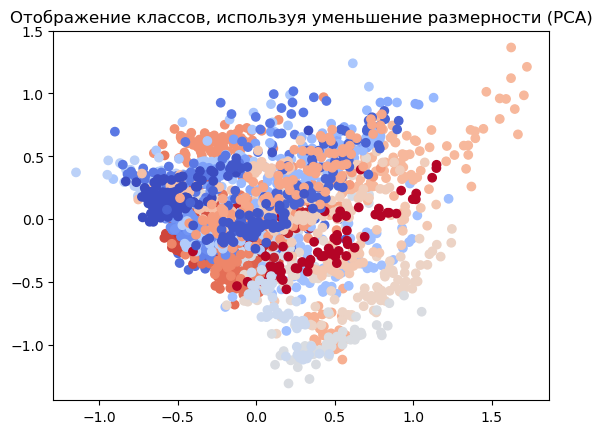

In [286]:
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=y, cmap='coolwarm')
plt.title('Отображение классов, используя уменьшение размерности (PCA)')
plt.show()

## Заметна линейная разделимость классов

In [270]:
ind_1 = df_pred[((df_pred.y_true!=df_pred.knn_pred)|(df_pred.y_true!=df_pred.svc_pred))&(df_pred.knn_pred!=df_pred.svc_pred)].index
ind_2 = df_pred[(df_pred.y_true!=df_pred.knn_pred)&(df_pred.y_true!=df_pred.svc_pred)].index

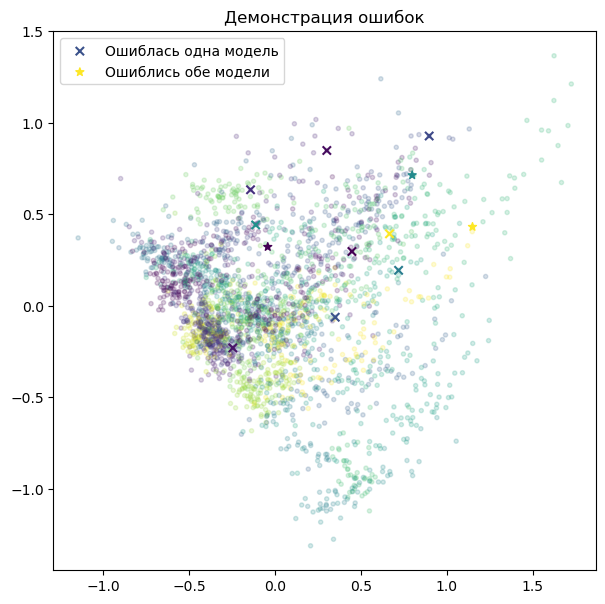

In [287]:
plt.figure(figsize=(7, 7))
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=y, alpha=0.2, marker = '.')
plt.scatter(X_reduced_pca[ind_1][:,0], X_reduced_pca[ind_1][:,1], c=y[ind_1], alpha=1, marker = 'x', label='Ошиблась одна модель')
plt.scatter(X_reduced_pca[ind_2][:,0], X_reduced_pca[ind_2][:,1], c=y[ind_2], alpha=1, marker = '*', label='Ошиблись обе модели')
plt.title("Демонстрация ошибок")
plt.legend()
plt.show()

## Так как чаще ошибается одна модель, решил попробовать stacking

In [272]:
estimators = [('svc', svc_pipe),('knn', knn_pipe)]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=10000), cv='prefit')
stack.fit(X_train, y_train)
stack_pred = stack.predict(X_test)

In [273]:
df_pred['stack_pred'] = stack_pred
df_pred[df_pred.y_true!=df_pred.stack_pred]

,y_true,knn_pred,svc_pred,stack_pred
2069,23,23,23,1
1543,4,4,4,30
196,3,3,3,5
1722,6,6,6,15
1299,8,8,4,4
1335,5,5,3,29
188,3,3,25,16
387,18,8,8,24
1352,5,5,5,3
2067,23,23,23,1


### Количество ошибок стало больше, чем при использовании одной модели

## Bagging

In [274]:
knn_bag = BaggingClassifier(estimator=knn_pipe, n_estimators=5, random_state=42, bootstrap=False, max_samples=1.0).fit(X_train, y_train)
knn_bag_pred = knn_bag.predict(X_test)

In [275]:
df_pred['knn_bag_pred'] = knn_bag_pred
df_pred[df_pred.y_true!=df_pred.knn_bag_pred]

,y_true,knn_pred,svc_pred,stack_pred,knn_bag_pred
775,12,23,12,12,23
2310,39,23,39,39,23
2009,11,2,11,11,2
2315,39,23,23,39,23
2497,28,11,11,28,11
387,18,8,8,24,8
371,18,23,18,18,23
1576,4,11,4,30,11


In [232]:
bag_params = {'estimator': [knn_pipe, svc_pipe],
              'n_estimators': np.arange(2,11),
              'random_state': [42],
              'bootstrap': [True, False],
              'max_samples': np.arange(0.2,1.2,0.2)}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
bag_grid = GridSearchCV(BaggingClassifier(), bag_params, verbose=1)
bag_grid.fit(X, y)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


GridSearchCV(estimator=BaggingClassifier(),
             param_grid={'bootstrap': [True, False],
                         'estimator': [Pipeline(steps=[('MaxAbsScaler',
                                                        MaxAbsScaler()),
                                                       ('KNN',
                                                        KNeighborsClassifier(algorithm='ball_tree',
                                                                             metric='euclidean',
                                                                             n_neighbors=1))]),
                                       Pipeline(steps=[('MaxAbsScaler',
                                                        MaxAbsScaler()),
                                                       ('SVC',
                                                        SVC(C=1.4,
                                                            kernel='linear'))])],
                         'max_samples': array([0.2, 0.4, 0.6, 0.8, 1. ]),
                         'n_estimators': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'random_state': [42]},
             verbose=1)

In [233]:
bag_grid.best_score_, bag_grid.best_params_

(0.9839694656488549,
 {'bootstrap': False,
  'estimator': Pipeline(steps=[('MaxAbsScaler', MaxAbsScaler()),
                  ('SVC', SVC(C=1.4, kernel='linear'))]),
  'max_samples': 1.0,
  'n_estimators': 2,
  'random_state': 42})

In [276]:
svc_bag = BaggingClassifier(estimator=svc_pipe, n_estimators=2, random_state=42, bootstrap=False, max_samples=1.0).fit(X_train, y_train)
svc_bag_pred = svc_bag.predict(X_test)

In [277]:
df_pred['svc_bag_pred'] = svc_bag_pred
df_pred[df_pred.y_true!=df_pred.svc_bag_pred]

,y_true,knn_pred,svc_pred,stack_pred,knn_bag_pred,svc_bag_pred
1299,8,8,4,4,8,4
2315,39,23,23,39,23,23
1335,5,5,3,29,5,3
2497,28,11,11,28,11,11
188,3,3,25,16,3,25
387,18,8,8,24,8,8
1189,21,21,11,11,21,11


### Кол-во ошибок совпадает с кол-вом ошибок при использовании одной модели

## Stacking + Bagging

In [290]:
estimators = [('svc_bag', svc_bag),('knn_bag', knn_bag), ('stack', stack)]
bag_stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=10000), cv='prefit')
bag_stack.fit(X_train, y_train)
bag_stack_pred = bag_stack.predict(X_test)

In [291]:
df_pred['bag_stack_pred'] = bag_stack_pred
df_pred[df_pred.y_true!=df_pred.bag_stack_pred]

,y_true,knn_pred,svc_pred,stack_pred,knn_bag_pred,svc_bag_pred,bag_stack_pred
1299,8,8,4,4,8,4,4
2315,39,23,23,39,23,23,23
2497,28,11,11,28,11,11,11
387,18,8,8,24,8,8,8
1576,4,11,4,30,11,4,11
1189,21,21,11,11,21,11,11


### На одну ошибку стало меньше

In [313]:
knn_pipe = Pipeline(steps=[('MaxAbsScaler', MaxAbsScaler()), ('KNN', KNeighborsClassifier(algorithm='ball_tree',
                                                                                          metric='euclidean',
                                                                                          n_neighbors=1,
                                                                                          weights='uniform'))])
svc_pipe = Pipeline(steps=[('MaxAbsScaler', MaxAbsScaler()), ('SVC', SVC(C=1.4, kernel='linear'))])
svc_pipe.fit(X_train, y_train)
knn_pipe.fit(X_train, y_train)
stack = StackingClassifier(estimators=[('svc', svc_pipe),('knn', knn_pipe)], final_estimator=LogisticRegression(max_iter=10000), cv='prefit')
stack.fit(X_train, y_train)
knn_bag = BaggingClassifier(estimator=knn_pipe, n_estimators=5, random_state=42, bootstrap=False, max_samples=1.0)
knn_bag.fit(X_train, y_train)
svc_bag = BaggingClassifier(estimator=svc_pipe, n_estimators=2, random_state=42, bootstrap=False, max_samples=1.0)
svc_bag.fit(X_train, y_train)
estimators = [('svc_bag', svc_bag),('knn_bag', knn_bag), ('stack', stack)]

In [334]:
results={}
for i in range(len(param_grid)):
    final_estimator=LogisticRegression(**param_grid[i])
    model = StackingClassifier(estimators=estimators, final_estimator=final_estimator, cv='prefit')
    model.fit(X_train, y_train)
    results[str(param_grid[i])]=model.score(X_test, y_test)

In [341]:
sorted(results.items(), key=lambda x:x[1])

[("{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 10000, 'C': 0.01}",
  0.030534351145038167),
 ("{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 10000, 'C': 0.001}",
  0.04770992366412214),
 ("{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 10000, 'C': 0.1}",
  0.9847328244274809),
 ("{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 10000, 'C': 0.001}",
  0.9866412213740458),
 ("{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 10000, 'C': 0.01}",
  0.9866412213740458),
 ("{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 10000, 'C': 0.1}",
  0.9866412213740458),
 ("{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 10000, 'C': 100}",
  0.9866412213740458),
 ("{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 10000, 'C': 1000}",
  0.9866412213740458),
 ("{'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 10000, 'C': 1}",
  0.9885496183206107),
 ("{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 10000, 'C': 1}",
  0.9885496183206107),
 ("{'solver': 

In [346]:
bag_stack_opt = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(solver='liblinear', 
                                                                                         max_iter=10000, 
                                                                                         penalty='l2',
                                                                                         C=10), cv='prefit')
bag_stack_opt.fit(X_train, y_train)
bag_stack_opt_pred = bag_stack_opt.predict(X_test)

In [350]:
df_pred['bag_stack_opt_pred'] = bag_stack_opt_pred
df_pred[df_pred.y_true!=df_pred.bag_stack_opt_pred]

,y_true,knn_pred,svc_pred,stack_pred,knn_bag_pred,svc_bag_pred,bag_stack_pred,bag_stack_opt_pred
1299,8,8,4,4,8,4,4,4
2315,39,23,23,39,23,23,23,23
2497,28,11,11,28,11,11,11,11
387,18,8,8,24,8,8,8,8
1189,21,21,11,11,21,11,11,11


### Подобрав Final Estimator получилось убрать ещё одну ошибку